In [26]:
import json
import random
import numpy as np
import math
import datetime

from sklearn.decomposition import PCA
from collections import Counter
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

### Data preprocessing

In [27]:
def data():
    maxlen = 50
    embedding_size = 50
    pca_embedding_dim = 16
    
    # importing the glove embeddings path 
    embeddings_path = '../data/glove.6B.50d-char.txt'
    
    # Indexing character vectors using glove word vectors
    embedding_vectors = {}
    with open(embeddings_path, 'r') as f:
        for line in f:
            line_split = line.strip().split(" ")
            vec = np.array(line_split[1:], dtype=float)
            char = line_split[0]
            embedding_vectors[char] = vec
#     print('Found %s char vectors.' % len(embedding_vectors))
    
    # loading the dataset
    with open('../data/dataset.json', 'r') as f:
        dataset = json.load(f)
        positives = dataset['positives']
        negatives = dataset['negatives']
    
    # dividing the dataset to make small models
    data_fraction = 1
    positives = positives[:int(data_fraction * len(positives))]
    negatives = negatives[:int(data_fraction * len(negatives))]
    print("Total Dataset: ", len(positives+negatives))
    
    # Dividing the negatives dataset between train, dev and test
    negatives_train = negatives[0: int(len(negatives) * .8)]
    negatives_dev = negatives[int(len(negatives) * .8): int(len(negatives) * .9)]
    negatives_test = negatives[int(len(negatives) * .9): ]
    print("Split sizes:")
    print(len(positives), len(negatives_train), len(negatives_dev), len(negatives_test))
    
    # Shuffling the data
    a = [(i, 0) for i in negatives_train]
    b = [(i, 1) for i in positives]
    combined = a + b
    random.shuffle(combined)
    shuffled = list(zip(*combined))
    text_X = shuffled[0]
    labels = shuffled[1]
    
    # tokenizing the input url's
    tk = keras.preprocessing.text.Tokenizer(char_level=True)
    tk.fit_on_texts(text_X)
    
    # List the vocabulary
    word_index = tk.word_index
    vocab_size = len(word_index) + 1
#     print(vocab_size)
#     print(word_index)
    
    # integer encode the documents
    sequences = tk.texts_to_sequences(text_X)

    # pad documents to a max length of 4 words
    data = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen) # by default the padding is post.
    labels = np.asarray(labels)
#     print('Shape of data tensor:', data.shape)
#     print('Shape of label tensor:', labels.shape)
    
    # Dividing the dataset into train and test.
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    # split the training data into a training set and a validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    # create a weight matrix for words in training docs
#     print('Preparing embedding matrix.')
    embedding_matrix = np.zeros((vocab_size, 50))
    for char, i in word_index.items():
        embedding_vector = embedding_vectors.get(char)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
#     print(embedding_matrix.shape)
    
    # PCA Embedding dimension
    pca = PCA(n_components = pca_embedding_dim)
    pca.fit(embedding_matrix[1:])
    embedding_matrix_pca = np.array(pca.transform(embedding_matrix[1:]))
    embedding_matrix_pca = np.insert(embedding_matrix_pca, 0, 0, axis=0)
    print("PCA matrix created")
    
    return (X_train, X_test, y_train, y_test, X_val, y_val, embedding_matrix, maxlen, vocab_size, word_index,
            positives, negatives_train, negatives_dev, negatives_test)

### Less complicated CNN Model

In [28]:
def create_model(embedding_matrix, vocab_size, maxlen):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, 50, input_length=maxlen, weights=[embedding_matrix]))
    model.add(keras.layers.Conv1D(128, 5, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    optimizer = keras.optimizers.Adam(lr = 0.001, decay = 0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta = 0.01)
    file_path = '../model_weights/keras_weights_GRU_full_dataset_without_pca.hdf5'
    checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, verbose=1, save_best_only=True)
    callbacks_list = [earlyStopping, checkpoint]
    print(model.summary())
    return model, callbacks_list

### Complicated Model

In [ ]:
# # Define the model and the layers
# print("Training the model:")
# embedding_layer = keras.layers.Embedding(vocab_size, 16, input_length=50, weights=[embedding_matrix_pca])
# sequence_input = keras.layers.Input(shape=(50,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)
# convs = []
# filter_sizes = [3,4,5]
# for filter_size in filter_sizes:
#     l_conv = keras.layers.Conv1D(filters=256, kernel_size=filter_size)(embedded_sequences)
#     l_batch = keras.layers.BatchNormalization()(l_conv)
#     l_act = keras.layers.Activation('relu')(l_batch)
#     l_drop = keras.layers.Dropout(0.3)(l_act)
#     l_pool = keras.layers.GlobalMaxPooling1D()(l_drop)
#     convs.append(l_pool)
    
# l_merge = keras.layers.concatenate(convs, axis=1)
# x = keras.layers.Dense(128, activation='relu')(l_merge)
# x = keras.layers.Dropout(0.4)(x)
# preds = keras.layers.Dense(1, activation='sigmoid')(x)
# model = keras.Model(sequence_input, preds)
# optimizer = keras.optimizers.Adam(lr = 0.001, decay = 0.0001)
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta = 0.01)
# file_path = '../model_weights/keras_weights_GRU_full_dataset_without_pca.hdf5'
# checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, verbose=1, save_best_only=True)
# callbacks_list = [earlyStopping, checkpoint]
# print(model.summary())

In [29]:
before_dataset = datetime.datetime.now()
(X_train, X_test, y_train, y_test, X_val, y_val, embedding_matrix, maxlen, vocab_size, word_index,
    positives, negatives_train, negatives_dev, negatives_test) = data()
after_dataset = datetime.datetime.now()
delta_dataset = after_dataset - before_dataset
print("Data Preprocessing time:", delta_dataset)

Total Dataset:  2926705
Split sizes:
1491178 1148421 143553 143553
PCA matrix created
Data Preprocessing time: 0:01:23.483864


In [30]:
training_start = datetime.datetime.now()
model, callbacks_list = create_model(embedding_matrix, vocab_size, maxlen)
history = model.fit(X_train, y_train, batch_size = 4096, epochs = 50, verbose=2, 
          validation_data=(X_val, y_val), callbacks = callbacks_list)
training_stop = datetime.datetime.now()
delta_training = training_stop - training_start
print("Model training time:", delta_training)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            1950      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 128)           32128     
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 128)           0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 35,379
Trainable params: 35,379
Non-trainable params: 0
__________________________________________________

### Plotting graphs

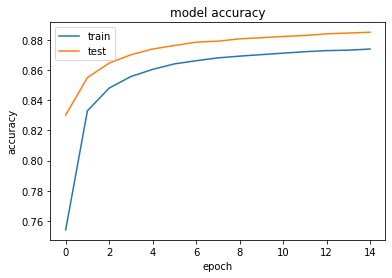

In [8]:
# plot training history
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

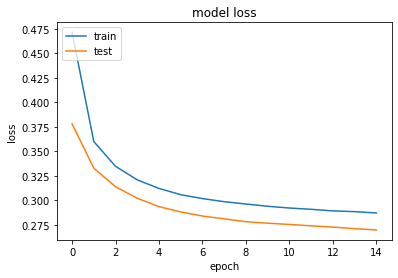

In [9]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# evaluate the model
before_train_evaluation = datetime.datetime.now()
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
after_train_evaluation = datetime.datetime.now()
delta_train_evaluation = after_train_evaluation - before_train_evaluation
print("Model evaluation time on training data", delta_train_evaluation)

before_test_evaluation = datetime.datetime.now()
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
after_test_evaluation = datetime.datetime.now()
delta_test_evaluation = after_test_evaluation - before_test_evaluation
print("Model evaluation time on testing data", delta_test_evaluation)

print('Training Loss: %.3f, Testing loss: %.3f' % (train_loss, test_loss) )
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model evaluation time on training data 0:01:03.613554
Model evaluation time on testing data 0:00:18.188018
Training Loss: 0.267, Testing loss: 0.268
Train: 0.887, Test: 0.886


In [12]:
# Saving the model and loading the saved model
model.save('../diagram/full_CNN_PCA.h5')

# model.save("../saved_models/full_model_CNN_with_pca_simpler.h5")
# keras.models.load_model('../saved_models/full_model_CNN_with_pca_simpler.h5')

In [13]:
import gc
gc.collect()

12905

In [31]:
# Like predict, but you pass in an array of URLs, and it is all
# vectorized in one step, making it more efficient
def predicts(text_X):
    X = np.zeros((len(text_X), maxlen), dtype=np.int)
    for i in range(len(text_X)):
        offset = max(maxlen - len(text_X[i]), 0)
        for t, char in enumerate(text_X[i]):
            if t >= maxlen:
                break
            X[i, t + offset] = word_index[char]
    preds = [pred[0] for pred in model.predict(X)]
    return preds

In [15]:
# Model Evaluation
# define a threshold value so that values below threshold will be classified as false_positive
threshold = 0.5
maxlen = 50

def evaluate_model(positives, negatives_train, negatives_dev, negatives_test, threshold):
    false_negatives = 0.0
    preds = predicts(positives)
    for pred in preds:
        if pred <= threshold:
            false_negatives += 1
    print(false_negatives / len(positives), "false negatives for positives set.")

    false_positives_train = 0.0
    preds = predicts(negatives_train)
    for pred in preds:
        if pred > threshold:
            false_positives_train += 1

    false_positives_dev = 0.0
    preds = predicts(negatives_dev)
    for pred in preds:
        if pred > threshold:
            false_positives_dev += 1

    false_positives_test = 0.0
    preds = predicts(negatives_test)
    for pred in preds:
        if pred > threshold:
            false_positives_test += 1

    print(false_positives_train / len(negatives_train), "false positive rate for negatives train.")
    print(false_positives_dev / len(negatives_dev), "false positive rate for negatives dev.")
    print(false_positives_test / len(negatives_test), "false positive rate for negatives test.")

evaluate_model(positives, negatives_train, negatives_dev, negatives_test, threshold)

0.1308951714684632 false negatives for positives set.
0.09093790517588933 false positive rate for negatives train.
0.09251635284529058 false positive rate for negatives dev.
0.09293431694217466 false positive rate for negatives test.


In [16]:
# Getting predictions on negative_dev set to find a suitable threshold value.

# defining the false positive rate which we can change.
fp_rate = 0.01

print("Getting threshold for fp_rate", fp_rate)
preds = predicts(negatives_dev)
preds.sort()
fp_index = math.ceil((len(negatives_dev) * (1 - fp_rate)))
threshold = preds[fp_index]

print("Using threshold", threshold) 

evaluate_model(positives, negatives_train, negatives_dev, negatives_test, threshold)

Getting threshold for fp_rate 0.01
Using threshold 0.89130497
0.33874359734384496 false negatives for positives set.
0.009723785963509897 false positive rate for negatives train.
0.009989341915529457 false positive rate for negatives dev.
0.009996307983810857 false positive rate for negatives test.


### Bloom Filter Implementation Using Murmur Hash Function

In [32]:
##  Adapted from https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/ 

import math 
import mmh3 
from bitarray import bitarray 

class BloomFilter(object): 
    
    ''' 
    Class for Bloom filter, using murmur3 hash function 
    '''
    
    def __init__(self, items_count,fp_prob): 
        ''' 
        items_count : int 
            Number of items expected to be stored in bloom filter 
        fp_prob : float 
            False Positive probability in decimal 
        '''
        # False posible probability in decimal 
        self.fp_prob = fp_prob 
        
        # Size of bit array to use 
        self.size = self.get_size(items_count,fp_prob) 
        
        # number of hash functions to use 
        self.hash_count = self.get_hash_count(self.size,items_count) 
        
        # Bit array of given size 
        self.bit_array = bitarray(self.size) 
                
        # initialize all bits as 0 
        self.bit_array.setall(0) 

    def add(self, item): 
        ''' 
        Add an item in the filter 
        '''
        digests = [] 
        for i in range(self.hash_count): 
            
            # create digest for given item. 
            # i work as seed to mmh3.hash() function 
            # With different seed, digest created is different 
            digest = mmh3.hash(item,i) % self.size 
            digests.append(digest) 

            # set the bit True in bit_array 
            self.bit_array[digest] = True

    def check(self, item): 
        ''' 
        Check for existence of an item in filter 
        '''
        for i in range(self.hash_count): 
            digest = mmh3.hash(item,i) % self.size 
            if self.bit_array[digest] == False: 

                # if any of bit is False then,its not present 
                # in filter 
                # else there is probability that it exist 
                return False
        return True
    
    @classmethod
    def get_size(self,n,p): 
        ''' 
        Return the size of bit array(m) to used using 
        following formula 
        m = -(n * lg(p)) / (lg(2)^2) 
        n : int 
            number of items expected to be stored in filter 
        p : float 
            False Positive probability in decimal 
        '''
        m = -(n * math.log(p))/(math.log(2)**2) 
        return int(m) 

    @classmethod
    def get_hash_count(self, m, n): 
        ''' 
        Return the hash function(k) to be used using 
        following formula 
        k = (m/n) * lg(2) 
        
        m : int 
            size of bit array 
        n : int 
            number of items expected to be stored in filter 
        '''
        k = (m/n) * math.log(2) 
        return int(k) 

In [33]:
def create_bloom_filter(data):
    print("Creating bloom filter")
    false_negatives = []
    # calling the predicts function 
    preds = predicts(data)
    for i in range(len(data)):
        if preds[i] <= threshold:
            false_negatives.append(data[i])
    print("Number of false negatives at bloom time", len(false_negatives))
    bloom_filter = BloomFilter(len(false_negatives), fp_rate / 2)
    for fn in false_negatives:
        bloom_filter.add(fn)
    print("Created bloom filter")
    return bloom_filter

bloom_filter = create_bloom_filter(positives)

Creating bloom filter
Number of false negatives at bloom time 474614
Created bloom filter


In [35]:
# Function to predict the output from the machine learning model
def predict(text_x):
    x = np.zeros((1, maxlen), dtype=np.int)
    offset = max(maxlen - len(text_x), 0)
    for t, char in enumerate(text_x):
        if t >= maxlen:
            break
        x[0, t + offset] = word_index[char]
    pred = model.predict(x)
    return pred[0][0]

def check_item(item):
    if predict(item) > threshold:
        return True
    return bloom_filter.check(item)

In [36]:
print("Bloom filter bits needed", bloom_filter.size)
print("Bloom filter size in bytes", (bloom_filter.size)/8)
print("Number of hash", bloom_filter.hash_count)
    
false_positives = 0.0
for neg in negatives_test:
    if check_item(neg):
        false_positives += 1
print("Test false positive rate: ", str(false_positives / len(negatives_test)))

Bloom filter bits needed 5233926
Bloom filter size in bytes 654240.75
Number of hash 7


KeyboardInterrupt: 